lambda 1 = 0.22771611167171305
lambda 2 = 0.08095077923534287
lambda 3 = 0.02567552416190144
lambda 4 = 0.19464065478190898
lambda 5 = 0.3228500953021631
lambda 6 = -0.010427177934742168
lambda 7 = 0.15859401278171262
Miu = -0.6590694023993862


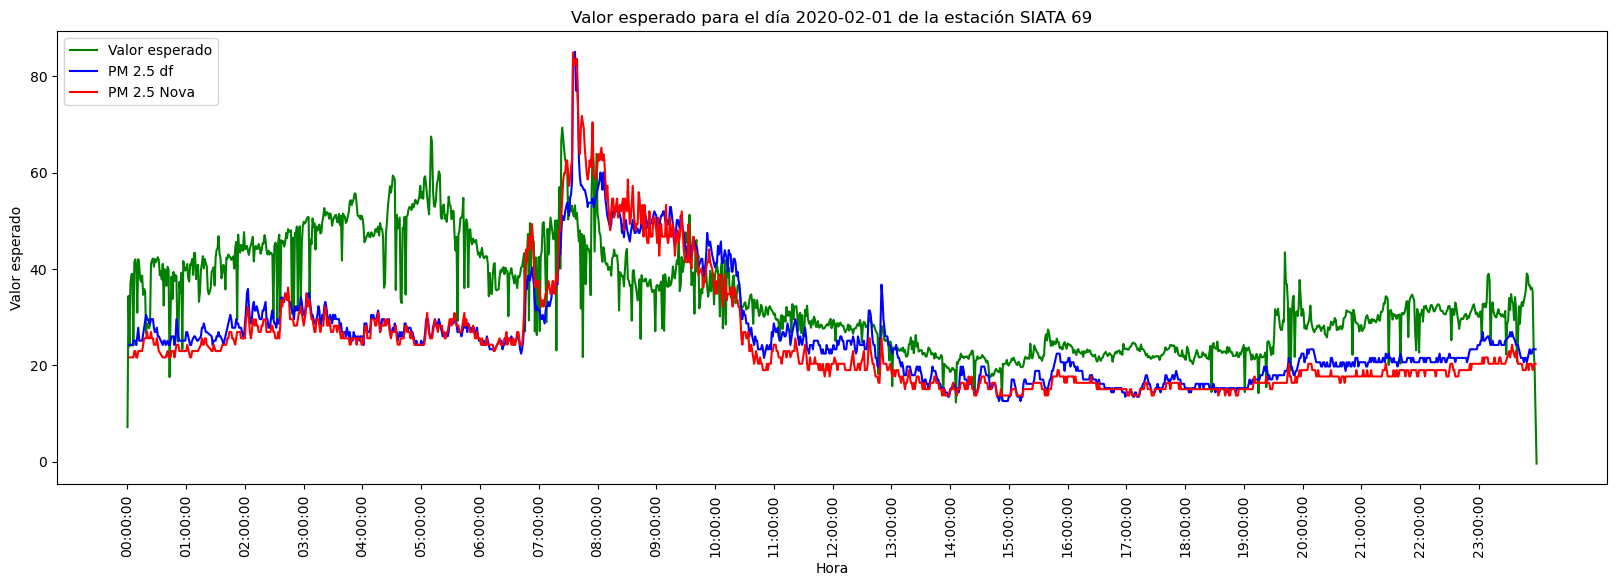

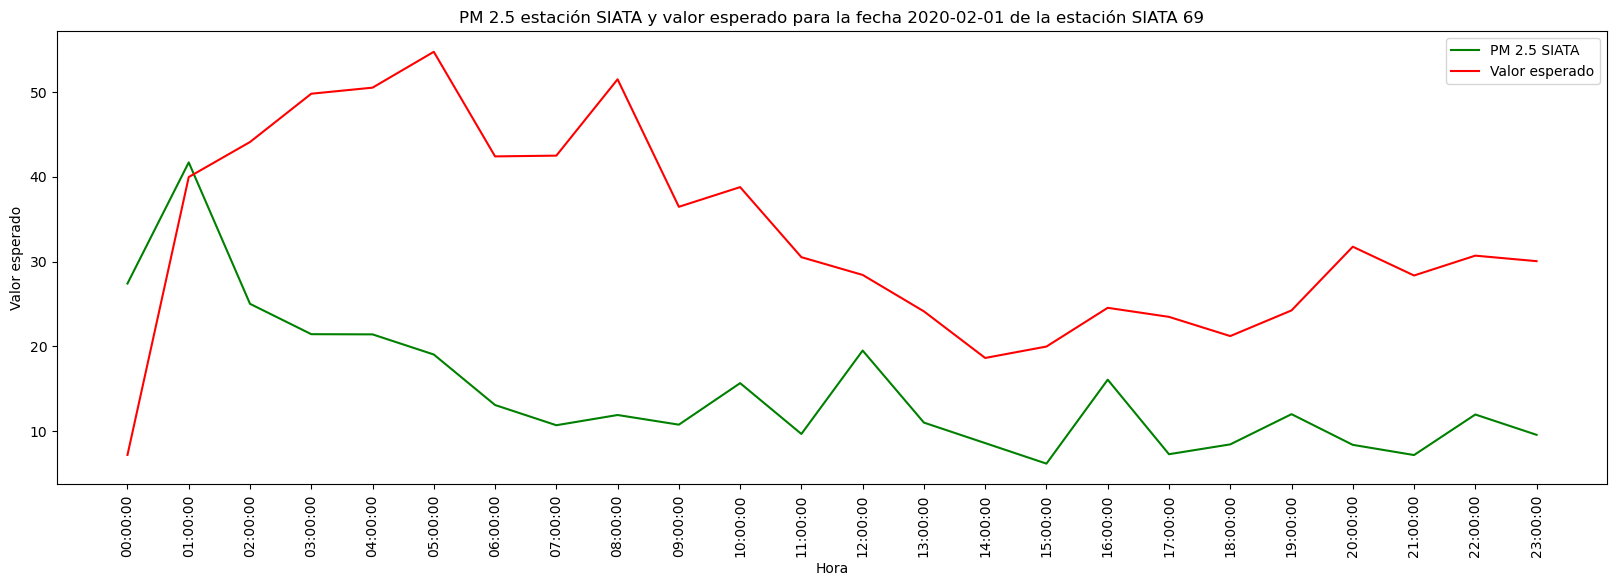

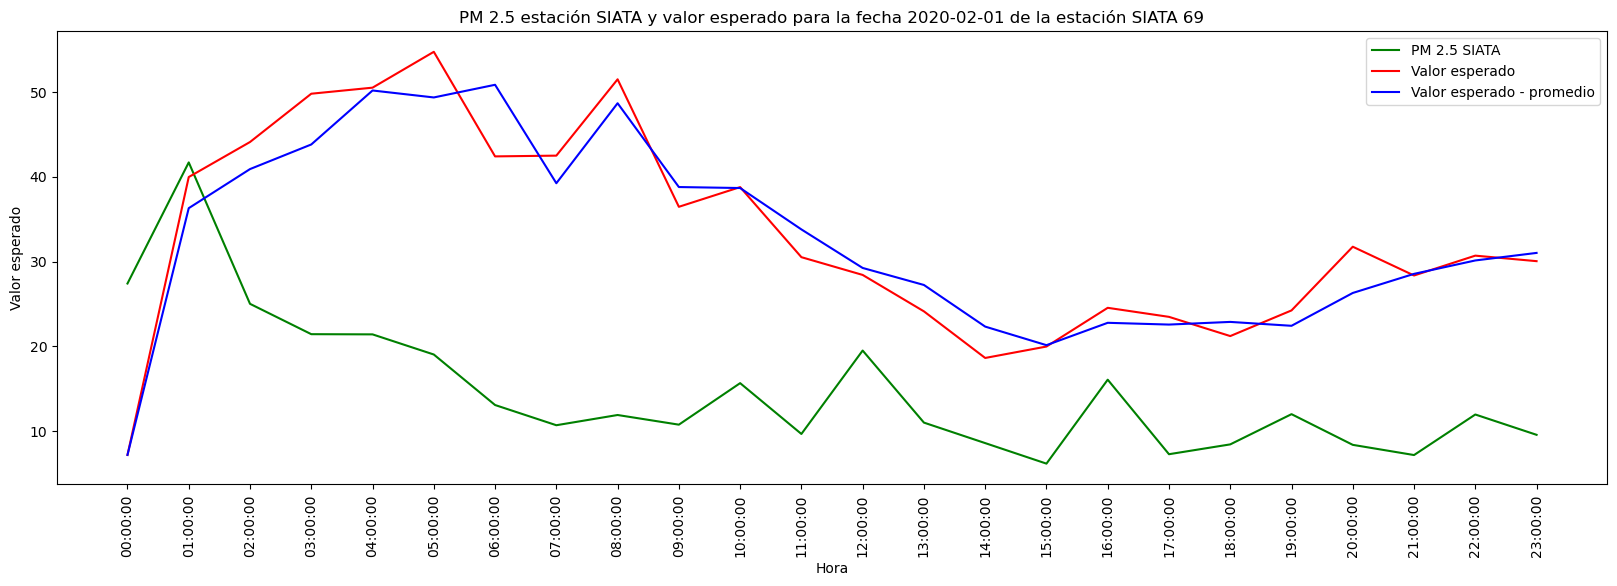

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math

datos = pd.read_csv("F:\PhD\Datos SIATA\Análisis\Descriptivo\datosCoordenados_CS.csv",sep=",")
clusters = pd.read_csv("F:\PhD\Datos SIATA\Análisis\Descriptivo\clusters.csv",sep=",")
coor_SIATA = pd.read_csv("F:\PhD\Datos SIATA\Análisis\Descriptivo\coordenadas_SIATA.csv",sep=",")
coor_CS = pd.read_csv("F:\PhD\Datos SIATA\Análisis\Descriptivo\coordenadas_CS.csv",sep=",")
datos_SIATA = pd.read_csv("F:\PhD\Datos SIATA\Análisis\Descriptivo\datos_SIATA.csv",sep=",")


fecha = "2020-02-01"
fechaSIATA = "01-01-20"
hora = "00:01:00"  # No se está usando
estacionSIATA = 69 #

# 1. FILTRADO DE DATOS ************************************************************

# 1.1 Exportación de los datos necesarios de los archivos
pm25 = datos.loc[:,["codigoSerial", "fecha", "hora", "pm25_df", "pm25_nova"]]
#pm25 = pm25.loc[pm25.loc[:,"hora"] == hora]
horas = pm25.hora.unique().tolist()
#horas = datos_SIATA.hora.unique().tolist()
pm25 = pm25.loc[pm25.loc[:,"fecha"] == fecha]
pm25.reset_index(inplace=True, drop=True)

# 1.2 Tomar los nodos del cluster y pasarlos a una lista.
#print(clusters.nodosCS.loc[clusters['codigoSIATA']==48].values.tolist()[0])
# 1. Se toma el daraframe de clusters y toma la fila que coincide con el valor de la estación,
# el resultado es índice y los valores, por lo que se toman solo los valores con el .value
# luego se converte a una lista y se toma la posición 0, esto es un string
# por ultimo se agregan el split y el strip para elimiar las llaves y tomar las comas como separador de la lista.  
nodos_CS = clusters.nodosCS.loc[clusters['codigoSIATA']==estacionSIATA].values.tolist()[0].strip('][').split(', ')
nodos_CS = [int(x) for x in nodos_CS]
nodos_CS.sort()


# 1.3 Filtrado de datos solo de los nodos del cluster
pm25_c = pd.DataFrame(columns=["codigoSerial", "fecha", "hora", "pm25_df", "pm25_nova"])
for i in nodos_CS:
    pm25_c = pd.concat([pm25_c, pm25.loc[pm25.loc[:,"codigoSerial"] == int(i)]])


# 1.4 Elimina de la lista los nodos del cluster que no tienen datos en la fecha indicada
nod = nodos_CS.copy()
for i in nod:
    filtro = pm25_c.loc[pm25_c.loc[:,"codigoSerial"] == int(i)]
    if len(filtro.codigoSerial) == 0:
        nodos_CS.remove(i)


# 2. CALCULO DE DISTANCIAS *********************************************************

# 2.1 Fórmula de Haversine
def haversine(lon1, lat1, lon2, lat2):
    #lon1 = Longitud punto 1
    #lat1 = Latitud punto 1
    #lon2 = Longitud punto 2
    #lat2 = Latitud punto 2
    
    # Radio de la tierra
    R = 6378  
    
    #Convertir grados decimales en radianes
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    
    #Formula
    dlon = lon2 - lon1 #Distancia entre longitudes
    dlat = lat2 - lat1 #Distancia entre latitudes
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2 
    c = 2 * math.asin(math.sqrt(a))
    return c * R


# 2.2 Calculo de las distancias entre nodos del cluster
lon_SIATA = float(coor_SIATA.longitud.loc[coor_SIATA.codigoSerial==estacionSIATA])
lat_SIATA = float(coor_SIATA.latitud.loc[coor_SIATA.codigoSerial==estacionSIATA])
# print("Longitud nodo SIATA", estacionSIATA,":",lon_SIATA)
# print("Latitud nodo SIATA", estacionSIATA,":",lat_SIATA)
distancias = {}
for i in nodos_CS:
    #cluster = []
    dist1 = {} # Distancias desde un nodo SIATA a cada nodo CS
    dist = haversine(lon_SIATA, 
                     lat_SIATA, 
                     coor_CS.longitud.loc[coor_CS["codigoSerial"]==i], 
                     coor_CS.latitud.loc[coor_CS["codigoSerial"]==i])
    dist1["SIATA"] = dist
    for j in nodos_CS:
        dist = haversine(coor_CS.longitud.loc[coor_CS["codigoSerial"]==i], 
                         coor_CS.latitud.loc[coor_CS["codigoSerial"]==i], 
                         coor_CS.longitud.loc[coor_CS["codigoSerial"]==j], 
                         coor_CS.latitud.loc[coor_CS["codigoSerial"]==j])
        dist1[str(j)] = dist

    distancias[str(i)] = dist1


# 3. GENERACIÓN DE LA MATRIZ *******************************************

# 3.1 Calculo de gamma_ij
matriz_var = np.ones((len(nodos_CS)+1, len(nodos_CS)+1))
matriz_var[len(nodos_CS), len(nodos_CS)]=0
vector_res = np.ones((len(nodos_CS)+1, 1))
fila = 0
for i in nodos_CS:
    col = 0
    for j in nodos_CS:
        resta = distancias[str(i)][str(j)]
        media = round(np.mean(resta**2),2) # Para que el np.mean????
        gamma = round(media/2,2)
        matriz_var[fila,col]=gamma
        col += 1
    resta = distancias[str(i)]["SIATA"]
    media = round(np.mean(resta**2),2) # Para que el np.mean????
    gamma = round(media/2,2)
    vector_res[fila,0]=gamma
    fila += 1

# 4. RESOLVIENDO LAS ECUACIONES LINEALES Y HALLANDO LAS INCOGNITAS.
lamb = np.linalg.solve(matriz_var, vector_res)
lamb = lamb.flatten().tolist()

for i in range(len(lamb)):
    if (i+1) == len(lamb):
        print("Miu =", lamb[i])
        continue
    print("lambda", i+1, "=", lamb[i])


# 5. HALLANDO EL VALOR ESTIMADO *****************************************
esperados = pd.DataFrame(columns=["hora", "valorEsperado"])
for h in horas:
    pm25 = pm25_c.loc[pm25_c.loc[:,"hora"] == h]
    #print(pm25)
    nod = pm25.codigoSerial.unique().tolist()
    Zo = 0
    j = 0
    for i in nod:
        #print("Hora:", h, "Zo va en:",Zo, "valor de lambda:", lamb[j])
        #print("Nodo:", i, "valor", pm25.pm25_df.loc[pm25.codigoSerial == i].values)
        Zo += lamb[nodos_CS.index(i)]*(pm25.pm25_df.loc[pm25.codigoSerial == i].values[0])
        #from scipy.spatial.distance import pdist
        
        j+= 1
    esperados = esperados.append({"hora":h,
                                 "valorEsperado":Zo},ignore_index=True)
    #print("Para la hora", h, "el valor estimado es:", Zo)

# 6. GRAFICO VALOR ESPERADO VS SENSOR DF Y NOVA ******************************************
plt.figure(figsize=(20, 6), dpi=100)
plt.plot(esperados["hora"],esperados["valorEsperado"],color="green",label="Valor esperado")
plt.plot(filtro["hora"],filtro["pm25_df"],color="blue",label="PM 2.5 df")
plt.plot(filtro["hora"],filtro["pm25_nova"],color="red",label="PM 2.5 Nova")

# 6.1 Etiquetas
plt.title("Valor esperado para el día "+ fecha +" de la estación SIATA "+str(estacionSIATA))
          #+" con media "+str(media)+" y desviación "+str(desviacion))
plt.xticks(np.arange(0, len(esperados.hora), 60), rotation=90)
plt.xlabel("Hora")
plt.ylabel("Valor esperado")
plt.legend(loc='upper left')
plt.show()


# 7. GRÁFICO VALOR ESPERADO VS DATOS ESTACIÓN SIATA **********************************

# 7.1 Gráfico con solo los datos de cada hora
datos_SIATA = datos_SIATA.loc[datos_SIATA.loc[:,"codigoSerial"] == estacionSIATA]
datos_SIATA = datos_SIATA.loc[datos_SIATA.loc[:,"fecha"] == fechaSIATA]

# 7.1.1 Filtrado de datos
horas = datos_SIATA.hora.unique().tolist()
esperados_h = pd.DataFrame(columns=["hora", "valorEsperado"])
for h in horas:
    esperados_h = esperados_h.append({"hora":h,
                                 "valorEsperado":esperados.valorEsperado.loc[esperados.hora == h].values[0]},ignore_index=True)

# 7.1.2 Datos para el gráfico
plt.figure(figsize=(20, 6), dpi=100)
plt.plot(datos_SIATA["hora"],datos_SIATA["pm25"],color="green",label="PM 2.5 SIATA")
plt.plot(esperados_h["hora"],esperados_h["valorEsperado"],color="red",label="Valor esperado")

# 7.1.3 Etiquetas
plt.title("PM 2.5 estación SIATA y valor esperado para la fecha "+ fecha +" de la estación SIATA "+str(estacionSIATA))
plt.xticks(np.arange(0, len(datos_SIATA.hora), 1), rotation=90)
plt.xlabel("Hora")
plt.ylabel("Valor esperado")
plt.legend(loc='upper right')
plt.show()


# 7.2 Gráfico con los datos por hora promediados

# 7.2.1 Cálculo de promedios
horas = datos_SIATA.hora.unique().tolist()
esperados_p = pd.DataFrame(columns=["hora", "valorEsperado"])
cont = 0  # Esto para qué???
for h in horas:
    prom = []
    ban = True
    while ban:
        prom.append(esperados.valorEsperado[cont])
        if esperados.hora[cont] == h:
            #print(prom)
            esperados_p = esperados_p.append({"hora":h,
                                 "valorEsperado":round(np.mean(prom),4)},ignore_index=True)
            ban = False
        cont +=1   # Esto para qué???
            
# 7.2.2 Datos para el gráfico
plt.figure(figsize=(20, 6), dpi=100)
plt.plot(datos_SIATA["hora"],datos_SIATA["pm25"],color="green",label="PM 2.5 SIATA")
plt.plot(esperados_h["hora"],esperados_h["valorEsperado"],color="red",label="Valor esperado")
plt.plot(esperados_p["hora"],esperados_p["valorEsperado"],color="blue",label="Valor esperado - promedio")

# 7.2.3 Etiquetas
plt.title("PM 2.5 estación SIATA y valor esperado para la fecha "+ fecha +" de la estación SIATA "+str(estacionSIATA))
plt.xticks(np.arange(0, len(datos_SIATA.hora), 1), rotation=90)
plt.xlabel("Hora")
plt.ylabel("Valor esperado")
plt.legend(loc='upper right')
plt.show()


## CÓDIGO QUE GENERA LA MATRIZ CON BASE EN LOS VALORES Y NO EN LAS DISTANCIAS
# matriz = np.ones((len(nodos_CS)+1, len(nodos_CS)+1))
# matriz[len(nodos_CS), len(nodos_CS)]=0
# fila = 0
# for i in nodos_CS:
#     col = 0
#     for j in nodos_CS:
#         filtro = pd.concat([pm25.loc[pm25.loc[:,"codigoSerial"] == int(i)], pm25.loc[pm25.loc[:,"codigoSerial"] == int(j)]])
#         filtro.reset_index(inplace=True, drop=True)  # Reinicia índice del DataFrame
#         resta = []
#         for k in fechas:
#             if filtro.fecha.loc[filtro['fecha']==k].count() == 2:
#                 valores = filtro.pm25_df.loc[filtro['fecha']==k].values
#                 resta.append((valores[0]-valores[1])**2)
                
#         media = round(np.mean(resta),2)
#         gamma = media/2
#         matriz[fila,col]=gamma
#         col += 1
#     fila += 1


#IDENTIFICACION DE NAN EN UNA MATRIZ Y ELIMINACIÓN DE LAS FILAS Y COLUMNAS DE NAN
# n = np.where(np.isnan(matriz))
# n = n[1].tolist()
# lim = 0
# for i in range(len(n)):
#     if n[i+1] - n[i] > 0:
#         lim = i+1
#     else:
#         break

# n = n[:lim+1]
# n.reverse()

# for i in n:
#     matriz = np.delete(matriz, i, axis=0)
#     matriz = np.delete(matriz, i, axis=1)
#     nodos_CS.pop(i)

#print(matriz)
        
                
                
            
            
        
        
        
            
        
        






# for i in fechas:
#     fecha = df.loc[df.loc[:,"fecha"] == i]
#     fecha.reset_index(inplace=True, drop=True)  # Reinicia índice del DataFrame
#     nodos = fecha['codigoSerial'].unique().tolist()
#     nodos.sort()
    
#     for j in nodos_CS:
        
#         if j not in nodos:
#             continue
#         for k in nodos_CS:
#             if j == k or k not in nodos:
#                 continue
            
#             print("Valor de j: ",j, " Valor de k", k)
#             print(fecha.pm25_df.loc[fecha['codigoSerial']==k].values)   
#             print("")
        


#nodos_CS = nodos.copy()

        
        # resta = df.pm25_df.loc[df['codigoSerial']==int(j)].values
        # print(resta)
        
        
    



    
    

In [5]:
esperados, esperados


(          hora  valorEsperado
 0     00:00:00       7.201979
 1     00:01:00      34.404080
 2     00:02:00      23.957964
 3     00:03:00      37.004129
 4     00:04:00      38.834295
 ...        ...            ...
 1435  23:55:00      35.424490
 1436  23:56:00      23.586352
 1437  23:57:00      19.525734
 1438  23:58:00       9.087385
 1439  23:59:00      -0.368215
 
 [1440 rows x 2 columns],
           hora  valorEsperado
 0     00:00:00       7.201979
 1     00:01:00      34.404080
 2     00:02:00      23.957964
 3     00:03:00      37.004129
 4     00:04:00      38.834295
 ...        ...            ...
 1435  23:55:00      35.424490
 1436  23:56:00      23.586352
 1437  23:57:00      19.525734
 1438  23:58:00       9.087385
 1439  23:59:00      -0.368215
 
 [1440 rows x 2 columns])